# Time Series Analysis

1. Get time series data for 10µs, 100 pixels (variable)
2. Average over pixels to obtain 1 averaged 10µs time series
3. FFT
4. Repeat with signal at $2\omega_0$ 

In [20]:
import os
import sys

import matplotlib.pyplot as plt
%matplotlib widget
import numpy as np

from presto import test
from presto.hardware import AdcMode, DacMode, AdcFSample, DacFSample

from tqdm import tqdm

# Network settings for Presto Hardware
ADDRESS = '130.237.35.90'   # IP Address
PORT    = 42873             # TCP Port

# Input (ADC) settings
INPUT_PORT = 9          # Dummy loopback port
ADC_ATT = 0.0           # dB, 0.0 to 27.0
INPUT_NCO = 1.5e9       # Hz, 0 to 10 GHz
DF = 100e3                # Hz

# Output (DAC) settings
OUTPUT_PORT = 9         # Dummy loopback port
DAC_CURR = 32_000       # μA, 2250 to 40500
AMP = 0.3                # FS, 0.0 to 1.0
FREQ = 100e6            # Hz, 0 to 500 MHz, intermediate frequency
PHASEI = 0.0            # rad
PHASEQ = PHASEI - np.pi / 2  # rad
OUTPUT_NCO = 8.3e9      # Hz, 0 to 10 GHz

# Configuration for the converter settings
CONVERTER_CONFIGURATION = {
    "adc_mode": AdcMode.Direct,
    "adc_fsample": AdcFSample.G2,
    "dac_mode": DacMode.Mixed02,
    "dac_fsample": DacFSample.G6,
}  

## Define Data acquisition script to collect pixels

In [21]:
# Define data acquisition function
def data_acquisition(
    address: str,
    port: int,
    converter_configuration: dict,
    input_port: int,
    adc_att: float,
    input_nco: float,
    output_port: int,
    dac_curr: int,
    amp: float,
    freq: float,
    phasei: float,
    phaseq: float,
    output_nco: float,
    df: float
):
    with test.Test(address=address, port=port, **converter_configuration) as tst:
        # get extra samples at the beginning and throw them away
        extra = 250
        # calculate number of samples from DF
        nr_samples = int(round(tst.get_fs("adc") / df))

        # NOTE:
        # in Mixed mode, maximum number for `extra + nr_samples` is 2**29 (512 MiS)
        # corresponding to ≈0.5 s of data, or ≈2 Hz resolution

        tst.hardware.configure_mixer(input_nco, in_ports=input_port, sync=False)
        tst.hardware.configure_mixer(output_nco, out_ports=output_port, sync=True)
        tst.hardware.set_adc_attenuation(input_port, adc_att)
        tst.hardware.set_dac_current(output_port, dac_curr)
        tst.hardware.sleep(0.1)

        tst.set_frequency(output_port, freq)
        tst.set_phase(output_port, phasei, phaseq)
        tst.set_scale(output_port, scale_i = amp, scale_q = amp)

        tst.hardware.set_run(False)
        tst.set_dma_source(input_port)
        tst.start_dma(extra + nr_samples)
        tst.hardware.set_run(True)
        tst.wait_for_dma()
        tst.stop_dma()
        data = tst.get_dma_data(extra + nr_samples)
        tst.hardware.check_adc_intr_status()

        # throw away initial `extra` data points
        data = data[-nr_samples:]

        # check which samples are close to saturation
        idx_sat = np.logical_or(data >= 32764, data <= -32764)
        nr_sat = np.sum(idx_sat)

        # convert data to full-scale (FS) units
        data = data / 32767

    return data

## Loop over data acquisition script to collect multiple pixels and average over the pixels

In [22]:
# Measurement Parameters
t_pix = 1 / DF  # μs, time per pixel, where DF is the frequency step size in Hz
f_sampling = 2e9        # Hz, sampling frequency of the ADC 
dt = 1 / f_sampling   # ns, time step between samples
n_pix = 200          # number of pixels in the measurement

# Loop over the number of pixels and acquire data
data_all = []
with tqdm(total=n_pix, ncols=80) as pbar:
    for i in range(n_pix):
        # acquire data for the current pixel
        data = data_acquisition(
            address=ADDRESS,
            port=PORT,
            converter_configuration=CONVERTER_CONFIGURATION,
            input_port=INPUT_PORT,
            adc_att=ADC_ATT,
            input_nco=INPUT_NCO,
            output_port=OUTPUT_PORT,
            dac_curr=DAC_CURR,
            amp=AMP,
            freq=FREQ,
            phasei=PHASEI,
            phaseq=PHASEQ,
            output_nco=OUTPUT_NCO,
            df=DF
        )
        # append the acquired data to the list
        data_all.append(data)

        # Update progress bar
        pbar.update(1)

data_all = np.array(data_all)  # convert list to numpy array for easier handling

print("Data acquisition complete.")

100%|█████████████████████████████████████████| 200/200 [00:25<00:00,  7.79it/s]

Data acquisition complete.


## Plot sample time series and FFT

(20000,)


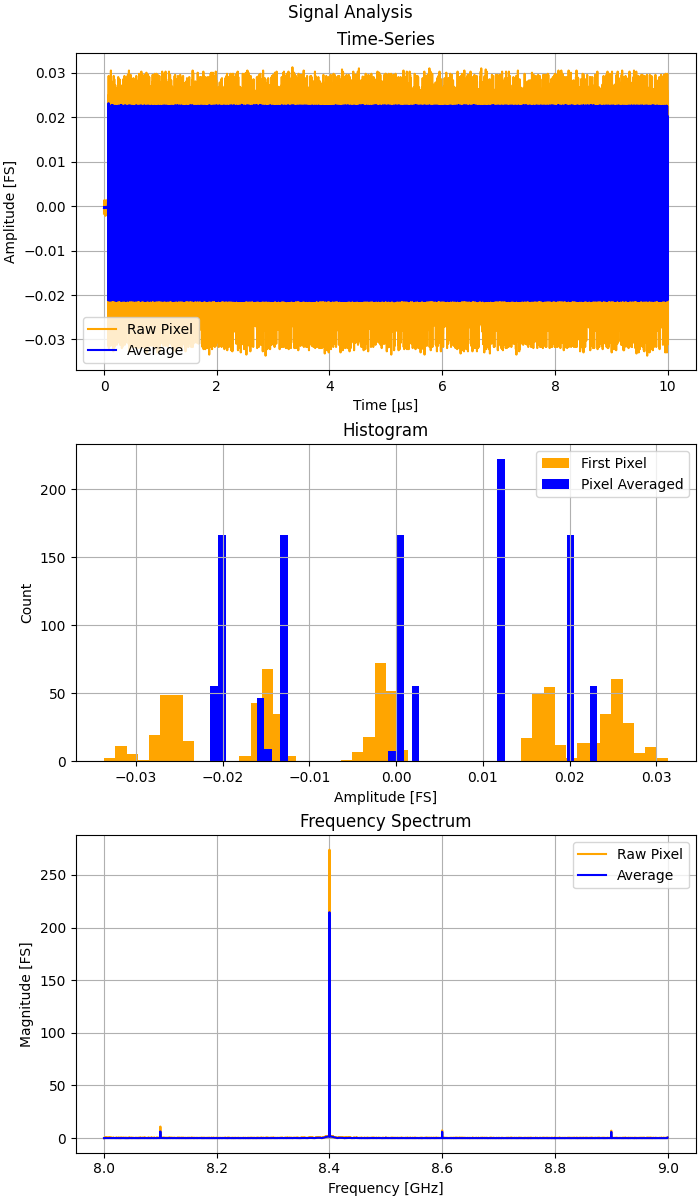

In [25]:
# Define time array
data_avg = np.mean(data_all, axis=0)  # pixel averaged data
data1 = data_avg - np.mean(data_avg)  # 
data2 = data_all[8] - np.mean(data_all[8])                        # get data for the first pixel
t_arr = dt * np.arange(len(data1)) * 1e6    # μs, convert from seconds
print(np.shape(t_arr))
# FFT
f_arr = 8 + 1e-9 * np.fft.rfftfreq(len(data1), dt)  # Hz, frequency array for FFT
fft_data1 = np.fft.rfft(data1)  # FFT of pixel averaged data
fft_data2 = np.fft.rfft(data2)  # FFT of single pixel data

# Plot
fig, ax = plt.subplots(
    nrows=3,                    # set to 2 for time and frequency domain plots
    ncols=1,
    constrained_layout=True, 
    figsize=(7, 12)
    )

ax1, ax2, ax3 = ax

# Plot pixel averaged and single pixel data together in the first subplot
ax1.plot(t_arr,data2, label="Raw Pixel", color = "orange")
ax1.plot(t_arr,data1, label="Average", color = "b")
ax1.set_xlabel("Time [μs]")
ax1.set_ylabel("Amplitude [FS]")
ax1.set_title("Time-Series")
ax1.legend()
ax1.grid()

# Plot histogram of the data in the second subplot
ax2.hist(data2, bins=50, density=True, label="First Pixel", color = "orange")
ax2.hist(data1, bins=50, density=True, label="Pixel Averaged", color = "blue")
ax2.set_xlabel("Amplitude [FS]")
ax2.set_ylabel("Count")
ax2.set_title("Histogram")
ax2.legend()
ax2.grid()

# Plot FFTs
ax3.plot(f_arr, np.abs(fft_data2), label="Raw Pixel", color = "orange")
ax3.plot(f_arr, np.abs(fft_data1), label="Average", color = "b")
ax3.set_xlabel("Frequency [GHz]")
ax3.set_ylabel("Magnitude [FS]")
ax3.set_title("Frequency Spectrum")
ax3.legend()
ax3.grid()

fig.suptitle("Signal Analysis")
plt.show()